In [1]:
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import glob
from pprint import pprint
import copy

In [2]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:
    
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def to_dict(npz):
    d = {}
    for k in npz:
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

def get_test_label_idx(data):
    n_class = data['params']['sim']['num_classes']
    n_train_per_class = data['params']['sim']['samples_per_class']
    n_epochs = data['params']['sim']['num_epochs']
    return n_class * n_train_per_class * n_epochs

def get_test_start_t(data):
    dt = data['params']['sim']['sample_dt']
    n_train = get_test_label_idx(data)
    return n_train * dt

def get_test_spikes_and_labels(data):
    spk = data['recs']['output'][0]['spikes']
    lbl = data['input']['labels']
    dt = data['params']['sim']['sample_dt']
    start_t = get_test_start_t(data)
    start_idx = get_test_label_idx(data)
    out_spk = []
    out_ids = lbl[start_idx:]
    for times in spk:
        ts = np.asarray(times)
        whr = np.where(ts >= start_t)
        out_spk.append(ts[whr])
    return out_spk, out_ids
        
def compress_spikes_list(spikes_list, start_t, end_t, randomize=True, period=10, decimals=0):
    sl = np.array(spikes_list)
    whr = np.where(np.logical_and(start_t <= sl, sl < end_t))[0]
    if len(whr) == 0:
        return []

    if randomize:
        t = np.around(
                np.random.uniform(start_t, start_t + period),
                decimals=decimals)
    else:
        t = np.around(
                period * sl[whr]/float(end_t - start_t),
                decimals=decimals)
    return [t]

def compress_spikes_array(spikes, start_t, end_t, randomize=True, period=10, decimals=0):
    return [
        compress_spikes_list(s, start_t, end_t, randomize, period, decimals)
            for s in spikes
    ]

def split_ssa(ssa, per_layer):
    n_layers = len(ssa) // per_layer
    d = {}
    for i in range(n_layers):
        d[i] = ssa[i * per_layer: (i + 1) * per_layer]
    return d

def get_max_t(spikes):
    max_t = -1
    max_id = -1
    for nid, times in enumerate(spikes):
        if len(times):
            local_max_t = np.max(times)
            if local_max_t > max_t:
                max_t = local_max_t
                max_id = nid
    return max_t, max_id

def in_dt(ts, st, et):
    ats = np.asarray(ts)
    whr = np.where(np.logical_and(st <= ats, ats < et))[0]
    if len(whr):
        return ats[whr]
    else:
        return []

    
def bin_spikes(spikes, dt, start_t, end_t):
    bins = np.arange(start_t, end_t, dt)
    
    bs = [[[] for _ in range(len(spikes))] 
              for _ in np.arange(start_t, end_t, dt)]

    for i, times in enumerate(spikes):
        inds = np.digitize(times, bins)
        for j in range(len(times)):
            b = inds[j] - 1
            bs[b][i].append(times[j])
    return bs

def norm_rate(binned_spikes, total=False):
    rate = [0. for _ in binned_spikes]
    for i, bs in enumerate(binned_spikes):
        w = 1./len(bs)
        rate[i] = np.sum([1 if (not total) and len(times) else len(times)
                            for times in bs]) * w
    return rate

def unique_times(bin_spikes, dt):
    rt = [set() for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ts = np.asarray(ts)
            rt[i].update(set(ts))
        
    return [np.asarray(list(s)) for s in rt]

def collapse_times(bin_spikes, dt):
    ct = [[] for _ in bin_spikes]
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct[i] += ts
        
    return ct#[np.asarray(s) for s in ct]

def relative_collapse_times(bin_spikes, dt):
    ct = []
    for i, curr_bin in enumerate(bin_spikes):
        for ts in curr_bin:
            ct += (np.asarray(ts) - dt * i).tolist()
        
    return ct#[np.asarray(s) for s in ct]



['../titan/data_gen0000000000_ind0000000000.npz', '../titan/data_gen0000000000_ind0000000001.npz', '../titan/data_gen0000000000_ind0000000002.npz', '../titan/data_gen0000000000_ind0000000003.npz', '../titan/data_gen0000000000_ind0000000004.npz']
280


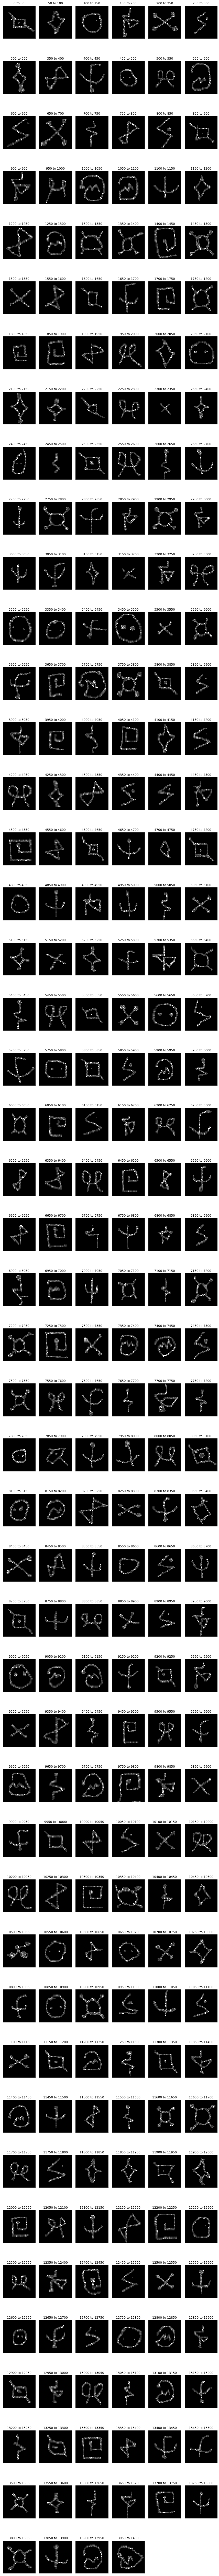

In [3]:
def get_n_rows(total, n_cols):
    return ((total//n_cols) + int(total%n_cols > 0))

fpath = '../titan/data_gen*.npz'
file_names = sorted( glob.glob(fpath) )
print(file_names)
fname = file_names[0]
cmaps = ['Blues', 'Greens', 'Oranges', 'Reds']
colors = ['blue', 'green', 'orange', 'red']

with np.load(fname, allow_pickle=True) as d:
    data = to_dict(d)
#     print(data['input'].keys())
    spikes_dict = data['input']['spikes'][0.0]
    shapes = data['input']['shapes']
    sim_ps = data['params']['sim']
    ind_ps = data['params']['ind']

    period = 10
    min_t = 1
    max_t = min_t + period
    last_t = -1
    flat = {}
    start_t = 0
    end_t = start_t + 14000
    dt = 50

    duration = sim_ps['duration']
    spikes_dict = data['input']['spikes'][0.0]

#         start_t = duration - n_test * dt
#         end_t = start_t + n_test *  dt

#     start_t = 0
#     end_t = 14000#0
#     end_t = duration
    bin_dict = {k: bin_spikes(spikes_dict[k], dt, start_t,  duration) 
                for k in spikes_dict}
    keys = sorted( bin_dict.keys() )
#     k0 = keys[0]
#     for k in keys[1:]:
#         for bidx in range(len(bin_dict[k0])):
#             for bl in bin_dict[k][bidx]:
#                 bin_dict[k0][bidx].append(bl)


    n_imgs = int((end_t - start_t) // dt)
    print(n_imgs)
    n_cols = 6
    n_rows = get_n_rows(n_imgs, n_cols)
    fw = 2.
    for k in bin_dict:
        plt.figure(figsize=(n_cols * fw, n_rows * fw * 1.5))
        shp = shapes[k][1], shapes[k][0]


        for img_idx, spk_bin in enumerate(bin_dict[k][:n_imgs]):
            ax = plt.subplot(n_rows, n_cols, img_idx + 1)
            ax.set_title("{} to {}".format(img_idx*dt, (img_idx+1)*dt))
#             plt.suptitle(f'Spikes from {st}ms to {et}ms')
            st = img_idx * dt
            img = np.zeros(shp)
            for pix_idx, times in enumerate(spk_bin):
                if len(times) == 0:
                    continue
                row_col = np.unravel_index(pix_idx, np.asarray(shp, dtype='int'))
                v = 1.
                for t in times:
                    v = dt/(1. + (t-st))
#                     v = 1.
                img[row_col] = v
            plt.imshow(img, cmap='gray', vmin=0)#cmaps[k], vmin=0, vmax=1)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        plt.show()
        
        continue
        
#         spikes = data['recs']['gain_control'][0]['spikes']

        
        for k in all_act:
            
            plt.figure()
            shp = shapes[k][1], shapes[k][0]
            ttt = all_act[k]
            ax = plt.subplot(1, 1, 1)
            ax.set_title(f"Type {k}")
            for nid, ts in enumerate(ttt):
                plt.plot(ts, nid * np.ones_like(ts), '.', color=colors[k], markersize=3)
            ax.set_xlim(st, et)
            ax.set_ylabel('Neuron id')
            ax.set_xlabel('Time [ms]')
            plt.tight_layout()
            plt.savefig(f'spikes_layer_{k}_{st}_{et}.png', dpi=150)
            plt.show()
            


In [4]:
fpath = '../titan/data_gen*0_ind*.npz'
file_names = sorted( glob.glob(fpath) )
print(file_names)
fname = file_names[0]
cmaps = ['Blues', 'Greens', 'Oranges', 'Reds']
colors = ['blue', 'green', 'orange', 'red']
active = []
with np.load(fname, allow_pickle=True) as d:
    data = to_dict(d)
#     print(data['input'].keys())
    recs = data['recs']['gain_control']
    skeys = sorted( recs.keys() )
#     spikes = [recs[k]['spikes'][0] for k in skeys]
    v = recs[0]['voltage']
    subs = 5
    n_neurons = v.shape[1]
    step = n_neurons // subs
    f = plt.figure(figsize=(10, subs * 8))
    for i, st in enumerate(np.arange(0, n_neurons, step)):
        ax = plt.subplot(subs, 1, i + 1)
        
        plt.plot(v[:, st:st+step])
        ax.set_xlabel('Time [ms]')
        
    plt.tight_layout()
    plt.show()
            


['../titan/data_gen0000000000_ind0000000000.npz', '../titan/data_gen0000000000_ind0000000001.npz', '../titan/data_gen0000000000_ind0000000002.npz', '../titan/data_gen0000000000_ind0000000003.npz', '../titan/data_gen0000000000_ind0000000004.npz']


AttributeError: 'list' object has no attribute 'shape'

['../titan/data_gen0000000000_ind0000000000.npz', '../titan/data_gen0000000000_ind0000000001.npz']


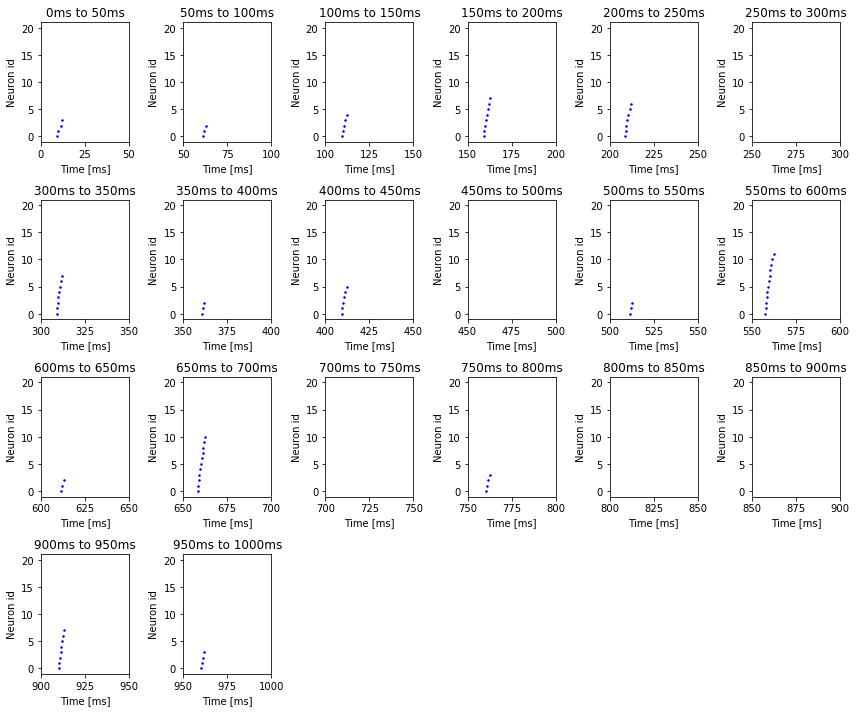

In [8]:
fpath = '../titan/data_gen*0_*.npz'
file_names = sorted( glob.glob(fpath) )
print(file_names)
fname = file_names[0]
cmaps = ['Blues', 'Greens', 'Oranges', 'Reds']
colors = ['blue', 'green', 'orange', 'red']
active = []
with np.load(fname, allow_pickle=True) as d:
    data = to_dict(d)
#     print(data['input'].keys())
    recs = data['recs']['gain_control']
    skeys = sorted( recs.keys() )
#     spikes = [recs[k]['spikes'][0] for k in skeys]
    spikes = recs[0]['spikes']
    
    period = 10
    min_t = 1
    max_t = min_t + period
    last_t = -1
    flat = {}
    start_t = 0
    end_t = start_t + 1000
    dt = 50
    n_plots = int( (end_t - start_t) // dt )
    n_cols = 6
    n_rows = n_plots // n_cols + int( n_plots % n_cols > 0 )
    fw = 2.
    plt.figure(figsize=(n_cols * fw, n_rows * fw *1.25))
#     plt.suptitle(f'Spikes from {st}ms to {et}ms')

    for i, st in enumerate(range(start_t, end_t, dt)):
#         break
        et = st + dt
        active[:] = [
                in_dt(ts, st, et) for i, ts in enumerate(spikes)
            ]
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.set_title(f'{st}ms to {et}ms')
        for nid, ts in enumerate(active):
            plt.plot(ts, nid * np.ones_like(ts), '.', color=colors[0], markersize=3)
        ax.set_xlim(st, et)
        ax.set_ylim(-1, len(spikes) + 1)
        ax.set_ylabel('Neuron id')
        ax.set_xlabel('Time [ms]')
    plt.tight_layout()
    plt.show()
            


x + y = 40
x = y - 10
y - 10 + y = 40
2y = 50
y = 25
x = 15

../titan/data_gen0000000000_ind0000000000.npz
{'database': ['Futurama'],
 'duration': 14000.0,
 'input_divs': (3, 5),
 'input_layers': 4,
 'input_shape': (56, 56),
 'kernel_pad': 3,
 'kernel_width': 7,
 'noisy_spikes_path': '/its/home/gp283/l2l-omniglot/L2L-OMNIGLOT',
 'num_classes': 14,
 'num_epochs': 1,
 'num_sims': 1,
 'on_juwels': False,
 'output_size': 280,
 'prob_noise': 0.0,
 'sample_dt': 50.0,
 'samples_per_class': 16,
 'spikes_path': '/its/home/gp283/omniglot_output_56',
 'steps': 1,
 'test_per_class': 4,
 'total_per_class': 20,
 'use_gabor': False}
{'A_minus': 9.331467879723233,
 'A_plus': 3.6888712360137434,
 'conn_dist': 17.0,
 'exp_prob': 0.19765735360294012,
 'expand': 8.695916648755144,
 'mushroom_weight': 0.6523842511848974,
 'out_prob': 0.22784522634056398,
 'out_weight': 0.23985904448544906,
 'w_max_mult': 1.2,
 'w_min_mult': -0.03486218567734227}
3136


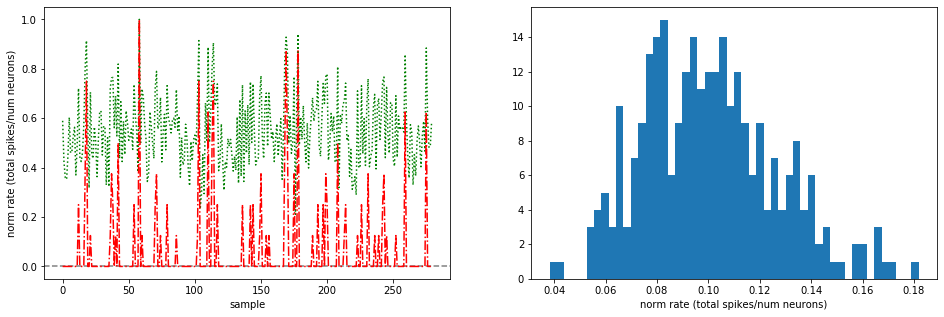

In [43]:
spikes = []
bs = []
rates = []
data = {}
d = '../titan'
for f in sorted(glob.glob(os.path.join(d, 'data*.npz')))[:1]:
    print(f)
    fname = os.path.basename(f)
    with np.load(f, allow_pickle=True) as npz:
#             print(sorted(npz['recs'].item()['mushroom'][0]['spikes'].keys()))
        sim_ps = npz['params'].item()['sim']
        ind_ps = npz['params'].item()['ind']
        pprint(sim_ps)
        pprint(ind_ps)
        dt = sim_ps['sample_dt']
        n_class = sim_ps['num_classes']
        n_test = sim_ps['test_per_class'] * n_class
        duration = sim_ps['duration']
        spikes_dict = npz['input'].item()['spikes'][0.0]

#         start_t = duration - n_test * dt
#         end_t = start_t + n_test *  dt
        
        start_t = 0
        end_t = 14000#0
        end_t = duration
        bin_dict = {k: bin_spikes(spikes_dict[k], dt, start_t,  end_t) 
                    for k in spikes_dict}
        keys = sorted( bin_dict.keys() )
        k0 = keys[0]
        for k in keys[1:]:
            for bidx in range(len(bin_dict[k0])):
                for bl in bin_dict[k][bidx]:
                    bin_dict[k0][bidx].append(bl)

#             bs[:] = bin_spikes(spikes, dt, end_t)
        bs = bin_dict[k0]
        print(len(bs[0]))

        rates = norm_rate(bs)
        
#         lh_spikes = npz['recs'].item()['gain_control'][0]['spikes']
        recs = npz['recs'].item()['gain_control']
        skeys = sorted( recs.keys() )
        lh_spikes = [recs[k]['spikes'][0] for k in skeys]

        lh_bins = bin_spikes(lh_spikes, dt, start_t, end_t)
        lh_rates = norm_rate(lh_bins)

        
        
        plt.figure(figsize=(16, 5))
        ax = plt.subplot(1, 2, 1)
    #     plt.suptitle(f"{ff}")
        plt.axhline(0.0, linestyle='--', color='gray')
        plt.plot(rates/np.max(rates), linestyle=':', color='green')
        plt.plot(lh_rates/np.max(lh_rates), linestyle='-.', color='red')
        ax.set_xlabel('sample')
        ax.set_ylabel('norm rate (total spikes/num neurons)')
    #         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

        ax = plt.subplot(1, 2, 2)
        plt.hist(rates, bins=50)
        ax.set_xlabel('norm rate (total spikes/num neurons)')
        plt.savefig(f"hist_rates_{k}.png", dpi=150)

        plt.show()



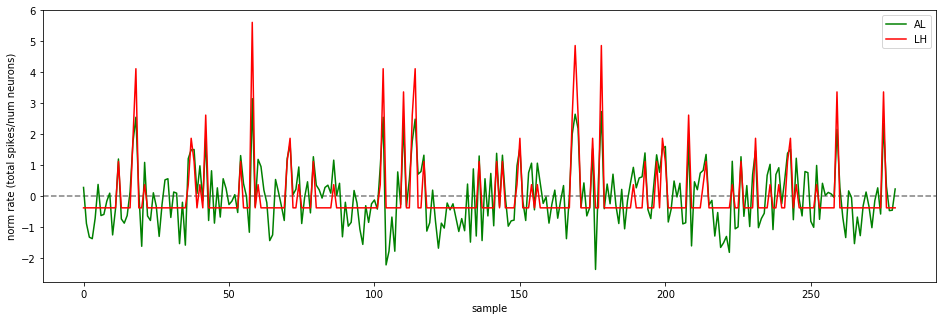

In [44]:
drates = (rates - np.mean(rates)) * ( 1. / np.std(rates) )
dlh_rates = (lh_rates - np.mean(lh_rates)) * ( 1. / np.std(lh_rates) )

plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 1, 1)
#     plt.suptitle(f"{ff}")
plt.axhline(0.0, linestyle='--', color='gray')
plt.plot(drates, color='green', label='AL')
plt.plot(dlh_rates, color='red', label='LH')
# plt.plot(drates == dlh_rates, '.')
ax.set_xlabel('sample')
ax.set_ylabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

# ax = plt.subplot(1, 2, 2)
# plt.hist(rates, bins=50)
# ax.set_xlabel('norm rate (total spikes/num neurons)')
# plt.savefig(f"hist_rates_{k}.png", dpi=150)
plt.legend()
plt.show()


In [29]:
x = np.arange(10)
print(x)
y = np.delete(x, np.s_[:])
print(y)

[0 1 2 3 4 5 6 7 8 9]
[]


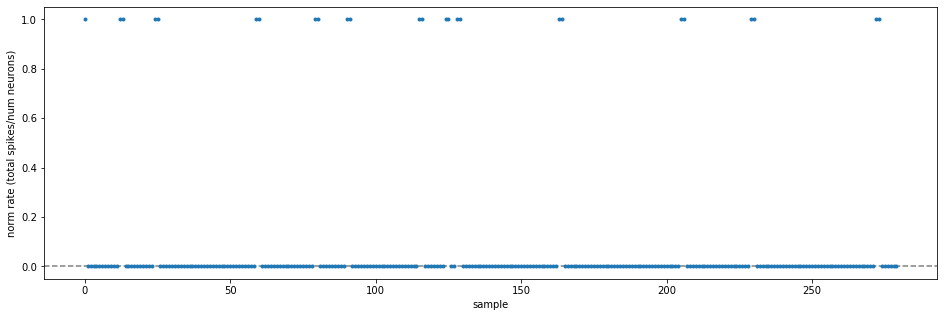

In [16]:
drates = np.asarray([np.sign(rates[i] - rates[i-1]) if i > 0 else 0
             for i in range(len(rates))])
dlh_rates = np.asarray([np.sign(lh_rates[i] - lh_rates[i-1]) if i > 0 else 0
             for i in range(len(lh_rates))])

plt.figure(figsize=(16, 5))
ax = plt.subplot(1, 1, 1)
#     plt.suptitle(f"{ff}")
plt.axhline(0.0, linestyle='--', color='gray')
# plt.plot(drates, '+', color='green')
# plt.plot(dlh_rates, 'x', color='red')
plt.plot(drates == dlh_rates, '.')
ax.set_xlabel('sample')
ax.set_ylabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

# ax = plt.subplot(1, 2, 2)
# plt.hist(rates, bins=50)
# ax.set_xlabel('norm rate (total spikes/num neurons)')
# plt.savefig(f"hist_rates_{k}.png", dpi=150)

plt.show()


../titan/data_gen0000000000_ind0000000000.npz
{'database': ['Futurama'],
 'duration': 14000.0,
 'input_divs': (3, 5),
 'input_layers': 4,
 'input_shape': (32, 32),
 'kernel_pad': 3,
 'kernel_width': 7,
 'noisy_spikes_path': '/its/home/gp283/l2l-omniglot/L2L-OMNIGLOT',
 'num_classes': 14,
 'num_epochs': 1,
 'num_sims': 1,
 'on_juwels': False,
 'output_size': 280,
 'prob_noise': 0.0,
 'sample_dt': 50.0,
 'samples_per_class': 14,
 'spikes_path': '/its/home/gp283/omniglot_output_32',
 'steps': 1,
 'test_per_class': 6,
 'total_per_class': 20,
 'use_gabor': False}
{'A_minus': 0.10726941619503659,
 'A_plus': 0.8046131734292823,
 'conn_dist': 12.0,
 'exp_prob': 30.0,
 'expand': 5.451763589194633,
 'mushroom_weight': 0.5,
 'out_prob': 0.1398579576827059,
 'out_weight': 0.5,
 'w_max_mult': 1.0,
 'w_min_mult': 0.0}
dict_keys(['labels', 'spikes', 'shapes', 'n_zones'])
num labels =   280
Futurama
['recs', 'weights', 'input', 'params', 'db_name', 'died', 'binned', 'correlations', 'analysis', 'fitnes

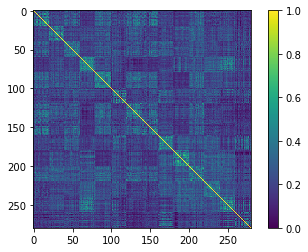

In [12]:
def bin_to_dict(bin_spikes, labels):
    un_lbl = np.unique(labels)
    vs = {l: [] for l in un_lbl}
    for i, s in enumerate(bin_spikes):
        v = [1 if len(spk) else 0 for spk in s]
        lbl = labels[i]
        vs[lbl].append(v)
    return vs
d = '../titan'
files = sorted(glob.glob(os.path.join(d, 'data*gen*0_ind*.npz')))
# for i, n in enumerate(files):
#     if 'Braille' in n:
#         break

spikes = []
bs = []
rates = []
data = {}
for f in files:
    print(f)
    fname = os.path.basename(f)
    with np.load(f, allow_pickle=True) as npz:
        d = npz['db_name'].item()
#         if 'Braille' not in d:
#             continue
#             print(sorted(npz['recs'].item()['mushroom'][0]['spikes'].keys()))
        sim_ps = npz['params'].item()['sim']
        ind_ps = npz['params'].item()['ind']
        pprint(sim_ps)
        pprint(ind_ps)

        dt = sim_ps['sample_dt']
        n_class = sim_ps['num_classes']
        n_test = sim_ps['test_per_class'] * n_class
        duration = sim_ps['duration']
        inputs = npz['input'].item()
        print(inputs.keys())
        labels = inputs['labels']
        print('num labels =  ', len(labels))
        spikes_dict = inputs['spikes'][0.0]
        print(d)
        print(list(npz.keys()))
        start_t = duration - n_test * dt
        end_t = start_t + n_test *  dt
        
        start_t = 0
        end_t = 3000#0
        end_t = duration
        start_idx = int(start_t // dt)
        end_idx = int(end_t // dt)
        
        bin_dict = {k: bin_spikes(spikes_dict[k], dt, start_t,  end_t) 
                    for k in spikes_dict}
        keys = sorted( bin_dict.keys() )
        k0 = keys[0]
        for k in keys[1:]:
            for bidx in range(len(bin_dict[k0])):
                for bl in bin_dict[k][bidx]:
                    bin_dict[k0][bidx].append(bl)

        bs = bin_dict[k0]
        vs = bin_to_dict(bs, labels[start_idx:end_idx])
        n_samp = end_idx - start_idx
        over = np.ones((n_samp, n_samp)) * np.nan
        cls = sorted(vs.keys())
        lens = [len(vs[c]) for c in cls]
        acc_lens = []
        for i0, c in enumerate(cls):
            if i0 == 0:
                acc_lens.append(0)
            else:
                acc_lens.append(lens[i0-1] + acc_lens[i0-1])
        
        for i0, c0 in enumerate(cls):
            print(i0)
            for i1, c1 in enumerate(cls):
#                 print(i0, i1)
                for j0, v0 in enumerate(vs[c0]):
                    for j1, v1 in enumerate(vs[c1]):
#                         if c0 == c1 and j0 == j1:
#                             continue
#                         v = np.logical_and(v0, v1).sum()
                        v0 = np.asarray(v0)
                        v1 = np.asarray(v1)
                        v = (v0 * v1).sum()/np.sqrt((v0**2).sum() * (v1**2).sum())
#                         print(c0, c1, j0, j1, acc_lens[i0] + j0, acc_lens[i1] + j1)
#                         print(v)

                        over[acc_lens[i0] + j0, acc_lens[i1] + j1] = v
        
        plt.figure()#figsize=(20, 20))
        plt.imshow(over, interpolation='none')
        plt.colorbar()
        plt.show()
        
    break
#         rates = norm_rate(bs)
#         plt.figure(figsize=(16, 5))
#         ax = plt.subplot(1, 2, 1)
#     #     plt.suptitle(f"{ff}")
#         plt.axhline(0.0, linestyle='--', color='gray')
#         plt.plot(rates)
#         ax.set_xlabel('sample')
#         ax.set_ylabel('norm rate (total spikes/num neurons)')
#     #         plt.savefig(f"rates_{dd}_{ff}.png", dpi=150)

#         ax = plt.subplot(1, 2, 2)
#         plt.hist(rates, bins=50)
#         ax.set_xlabel('norm rate (total spikes/num neurons)')
#         plt.savefig(f"hist_rates_{k}.png", dpi=150)

#         plt.show()



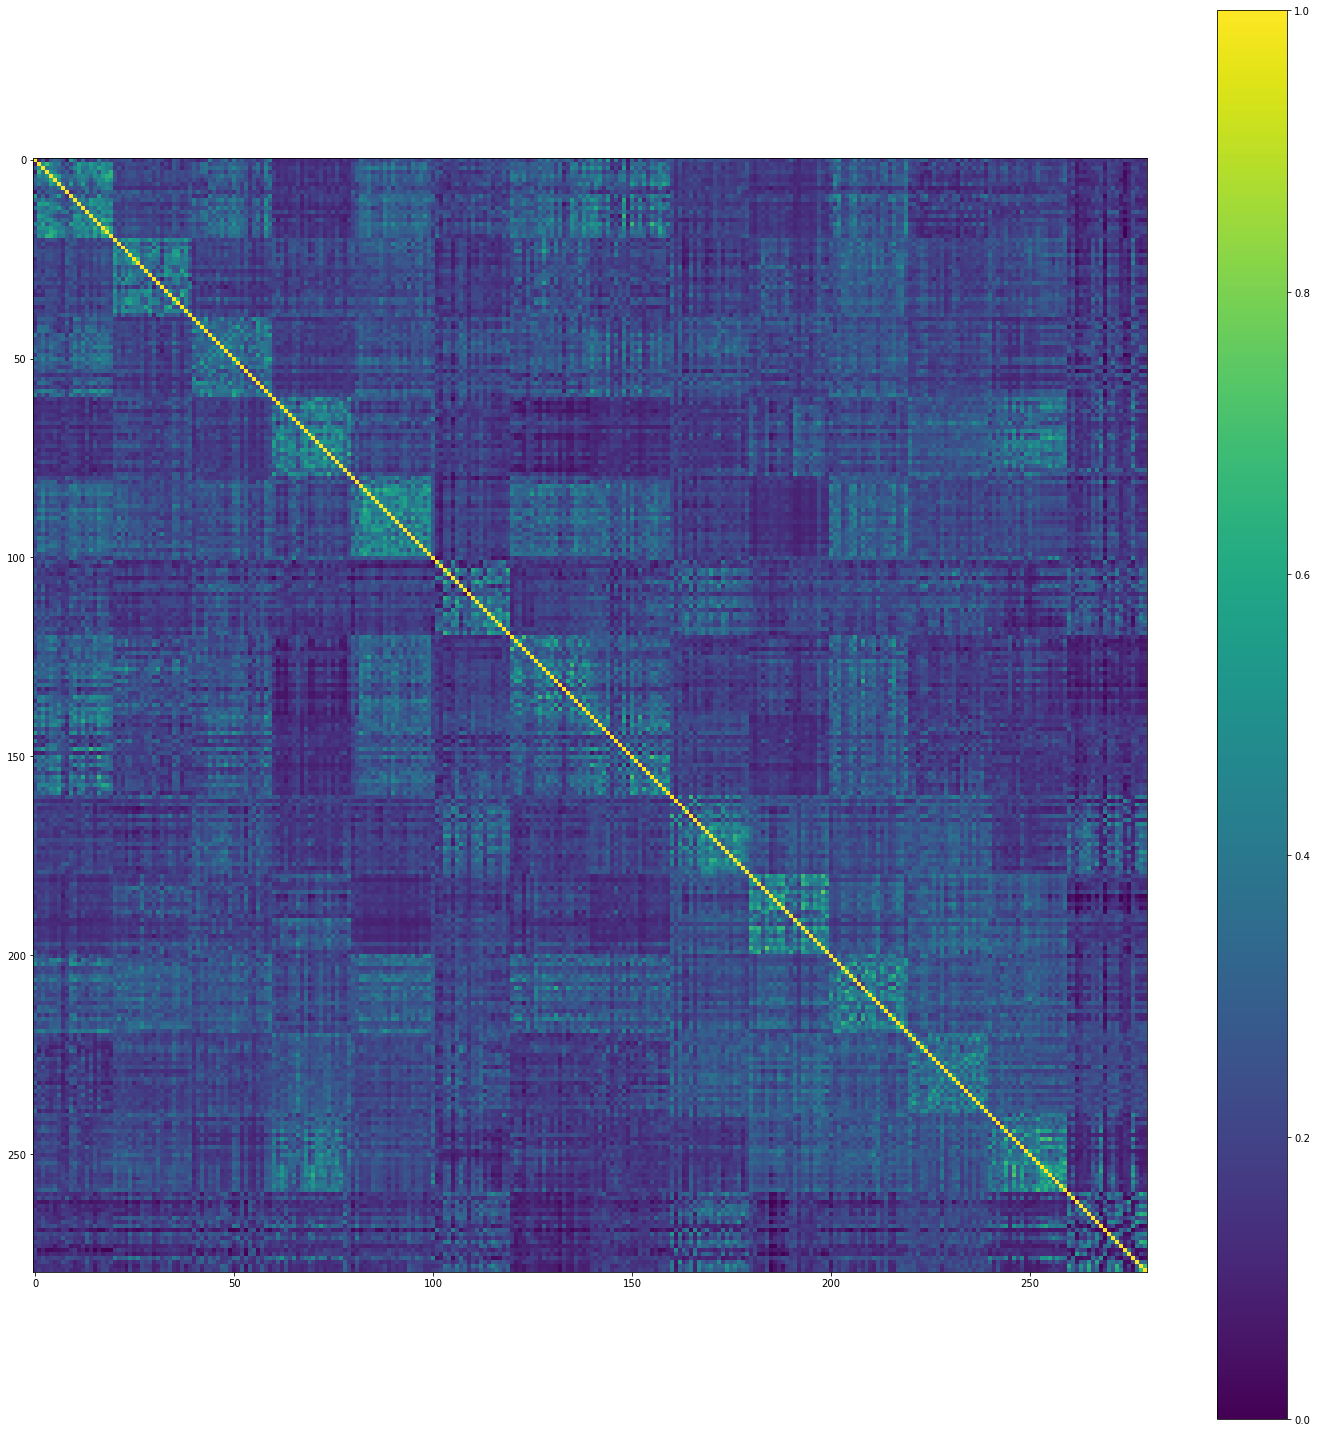

In [9]:
plt.figure(figsize=(20, 20))
plt.imshow(over, interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.savefig('cross_correlation_spikes_new_{}.png'.format(d), dpi=150)
plt.show()


dict_keys(['image_batch_index', 'spike_source_array', 'scaling', 'alphabet', 'timestep', 'label', 'color_image', 'focal_spikes', 'kernels', 'keepers', 'grayscale_image', 'alpha_idx', 'scaled_image'])


<ipython-input-45-70f2717866d3>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


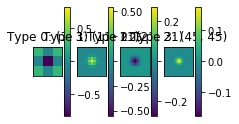

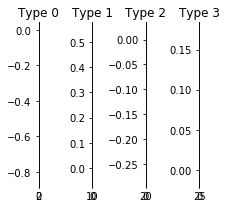

In [45]:
fpath = '../titan/alpha*.npz'
file_names = sorted( glob.glob(fpath) )
fname = file_names[0]

with np.load(fname, allow_pickle=True) as d:
    dd = to_dict(d)
    print(dd.keys())
    kernels = dd['kernels']
    fw = 3.
    plt.figure(figsize=(len(spikes_dict) * fw, fw * 1.0))
#     plt.suptitle('Centre-surround kernels')
    for k in kernels:
        ax = plt.subplot(1, len(kernels), k + 1)
        shp = kernels[k].shape
        vmax = np.abs(kernels[k]).max()
        ax.set_title(f'Type {k}: {shp}')
        ax.set_xticks([])
        ax.set_yticks([])
        im = plt.imshow(kernels[k], vmin=-vmax, vmax=vmax)
        plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(f'image_kernels.png', dpi=150)
    plt.show()
    
    
    plt.figure(figsize=(len(spikes_dict) * fw, fw * 1.0))
#     plt.suptitle('Centre-surround kernels')
    for k in kernels:
        ax = plt.subplot(1, len(kernels), k + 1)
        shp = kernels[k].shape
        vmax = np.abs(kernels[k]).max()
        ax.set_title(f'Type {k}')
#         ax.set_xticks([])
#         ax.set_yticks([])
        im = plt.plot(kernels[k][shp[0]//2, :])
        plt.axhline(0, linewidth=1, color='gray', linestyle='--')
        plt.axvline(shp[0]//2, linewidth=1, color='gray', linestyle='--')
        
    plt.tight_layout()
    plt.savefig(f'sideview_image_kernels.png', dpi=150)
    plt.show()

In [137]:
fpath = '../titan/input_spikes_Futurama*.npz'
file_names = sorted( glob.glob(fpath) )
fname = file_names[0]

with np.load(fname, allow_pickle=True) as d:
    dd = to_dict(d)
    print(dd.keys())
    print(dd['spikes'].keys())
    print(dd['shapes'])
    spikes_dict = dd['spikes']
    shapes = dd['shapes']
    period = 10
    min_t = 1
    max_t = min_t + period
    last_t = -1
    flat = {}
    start_t = 0#10300
    end_t = start_t + 100
    dt = 50
    
    for st in range(start_t, end_t, dt):
        et = st + dt
        plt.figure()
        for k in spikes_dict:
            shp = shapes[k][1], shapes[k][0]
            active = [
                i for i, ts in enumerate(spikes_dict[k])
                if len( in_dt(ts, st, et) ) > 0 
            ]
            print(active)
            img = np.zeros(shp)
            img[np.unravel_index(active, shp)] = 1
            plt.subplot(1, len(spikes_dict), k + 1)
            plt.imshow(img)
        plt.show()
        
                
        for k in spikes_dict:
            plt.figure()
            shp = shapes[k][1], shapes[k][0]
            active = [in_dt(np.asarray(ts), st, et) 
                      for ts in spikes_dict[k]]
#             print(active)
#             ttt = [np.asarray(spikes_dict[k][i])[np.asarray(w).astype('int')] for i, w in enumerate(active)]
            ax = plt.subplot(1, 1, 1)
            ax.set_title(f"type {k}: start {st} to {et}")
            for nid, ts in enumerate(active):
                plt.plot(ts, nid * np.ones_like(ts), '.b')
            ax.set_xlim(st, et)
            plt.show()

dict_keys(['labels', 'shapes', 'spikes'])
dict_keys([0])
{0: [56, 56]}
[]


TypeError: indices must be integral: the provided empty sequence was inferred as float. Wrap it with 'np.array(indices, dtype=np.intp)'

<Figure size 432x288 with 0 Axes>

['label', 'color_image', 'grayscale_image', 'scaled_image', 'focal_spikes', 'spike_source_array', 'timestep', 'image_batch_index', 'scaling', 'kernels', 'alphabet', 'alpha_idx', 'keepers']
0.305
{0: [1, 1]}
dict_keys([0])
{0: (32, 32)}


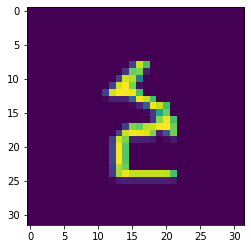

(32, 32)


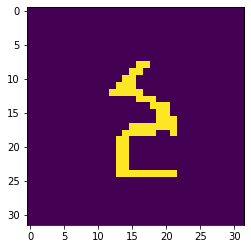

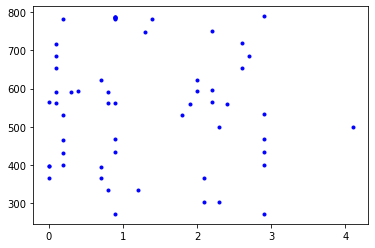

In [9]:
fpath = '../titan/32x32/alpha_*.npz'
file_names = sorted( glob.glob(fpath) )
fname = file_names[3]


def to_d(npz):
    d = {}
    for k in npz:
        try:
            d[k] = npz[k].item()
        except:
            print(type(k))
            print(k)
            d[k] = npz[k]
    return d

with np.load(fname, allow_pickle=True) as d:
    print([k for k in d.keys()])
    ssa = d['spike_source_array']
    scaled = d['scaled_image']
    size = scaled.size
    print(d['scaling'])
#     print(d['keepers'])
    keeps = d['keepers'].item()
    print(keeps)
#     print(d['kernels'])
#     dd = to_d(d)
    spikes_dict = split_ssa(ssa, size)
    print(spikes_dict.keys())
    shapes = {k: scaled.shape#(np.asarray(img.shape)/np.asarray(keeps[k])).astype('int')
              for k in keeps}
    print(shapes)
    plt.figure()
    plt.imshow(scaled)
    plt.show()
#     dd = to_dict(d)
#     print(dd.keys())
#     print(dd['spikes'].keys())
#     print(dd['shapes'])
#     spikes_dict = dd['spikes']
#     shapes = dd['shapes']
#     period = 10
#     min_t = 1
#     max_t = min_t + period
#     last_t = -1
    flat = {}
    start_t = 0.
    end_t = 500.
    dt = 50
    for k in spikes_dict:
        local_last_t, _ = get_max_t(spikes_dict[k])
        if local_last_t > last_t:
            last_t = local_last_t
        flat[k] = spikes_dict[k]#\
#            compress_spikes_array(
#                 spikes_dict[k], 
#                 start_t, end_t,
#                 randomize=bool(0), 
#                 period=dt//3, 
#                 decimals=0)
    plt.figure()
    for k in flat:
        shp = shapes[k]
        print(shp)
        active = [
            i for i, ts in enumerate(flat[k])
            if len( in_dt(ts, start_t, end_t) ) > 0 
        ]
        img = np.zeros(shp)
        if len(active):
            rows, cols = np.unravel_index(active, shp)
            img[rows.astype('int'), cols.astype('int')] = 1
        plt.subplot(1, len(flat), k + 1)
        im = plt.imshow(img)
#         plt.colorbar(im)
    plt.show()
    
    for k in flat:
        plt.figure()
        ax = plt.subplot(1, 1, 1)
        for nid, times in enumerate(flat[k]):
            im = plt.plot(times, nid * np.ones_like(times), '.b')
#         ax.set_xlim(start_t, start_t + dt)
        plt.show()
        
#     start_t = 0
#     end_t = 1000
#     for st in range(start_t, end_t, dt):
#         et = st + dt
#         plt.figure()
#         for k in spikes_dict:
#             shp = shapes[k]
#             print(shp)
#             active = [
#                 i for i, ts in enumerate(spikes_dict[k])
#                 if len( in_dt(ts, st, et) ) > 0 
#             ]
#             img = np.zeros(shp)
#             if len(active):
#                 rows, cols = np.unravel_index(active, shp)
#                 img[rows.astype('int'), cols.astype('int')] = 1
#             plt.subplot(1, len(spikes_dict), k + 1)
#             plt.imshow(img)
#         plt.show()

In [5]:
from scipy import misc
import cv2

# print(os.getcwd())
d = 'Latin'
d = 'Futurama'
# d = 'Braille'
# d = 'Korean'
centered = bool(1)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 56
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)

over = np.ones((n_samp * n_class, n_samp * n_class)) * np.nan

img0 = np.zeros((size, size))
img1 = np.zeros((size, size))
for i0, c0 in enumerate(classes):
    files0 = sorted(glob.glob(os.path.join(path, c0, '*.png')))
    print(c0)
    for i1, c1 in enumerate(classes):
        files1 = sorted(glob.glob(os.path.join(path, c1, '*.png')))
#         print(c0, c1)
        for j0, f0 in enumerate(files0):
            for j1, f1 in enumerate(files1):
                
#                 if i0 == i1 and j0 == j1:
#                     continue
                row, col = i0 * n_samp + j0, i1 * n_samp + j1
#                 print(n_class, n_samp, i0, i1, j0, j1, row, col)
                
                img0[:] = cv2.resize(cv2.imread(f0, cv2.IMREAD_GRAYSCALE),
                                     (size, size)) == 0
                
                if centered:
                    whr = np.where(img0 > 0)
                    r0 = -(np.mean(whr[0]) - (size // 2))
                    c0 = -(np.mean(whr[1]) - (size // 2))
                    T = np.float32([[1, 0, c0], [0, 1, r0]])
                    img0[:] = cv2.warpAffine(img0, T, (size, size))

                img1[:] = cv2.resize(cv2.imread(f1, cv2.IMREAD_GRAYSCALE),
                                     (size, size)) == 0
                
                if centered:
                    whr = np.where(img1 > 0)
                    r0 = -(np.mean(whr[0]) - (size // 2))
                    c0 = -(np.mean(whr[1]) - (size // 2))
                    T = np.float32([[1, 0, c0], [0, 1, r0]])
                    img1[:] = cv2.warpAffine(img1, T, (size, size))

                v = (img0 * img1).sum() / np.sqrt((img0**2).sum() * (img1**2).sum())
                over[row, col] = v

#                 print(i0, i1, j0, j1, v, size*size)
                
                
                


14 20 280
character01
character02
character03
character04
character05
character06
character07
character08
character09
character10
character11
character12
character13
character14


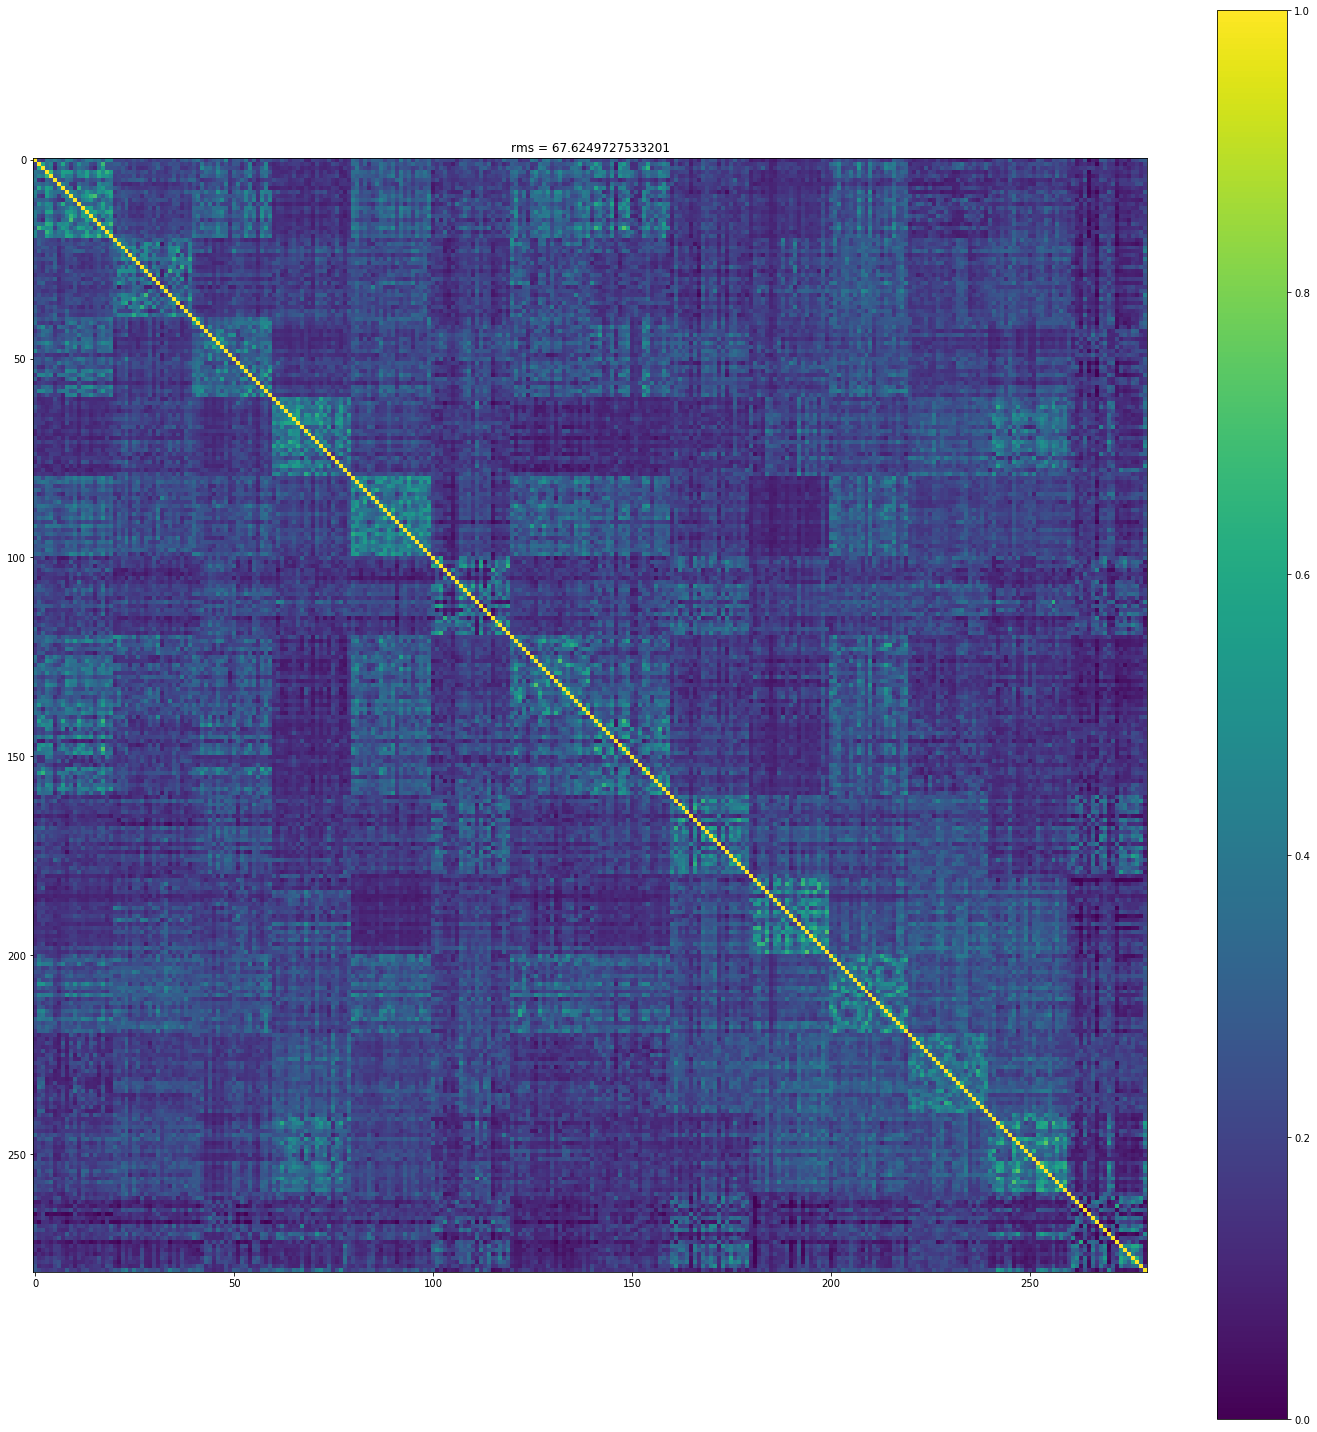

In [6]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1)
ax.set_title("rms = {}".format(np.sqrt(np.sum(over**2))))
plt.imshow(over, interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.savefig('cross_correlation_characters_{}_centered_{}.png'.format(d, centered), dpi=150)
plt.show()

14 20 280
2 8


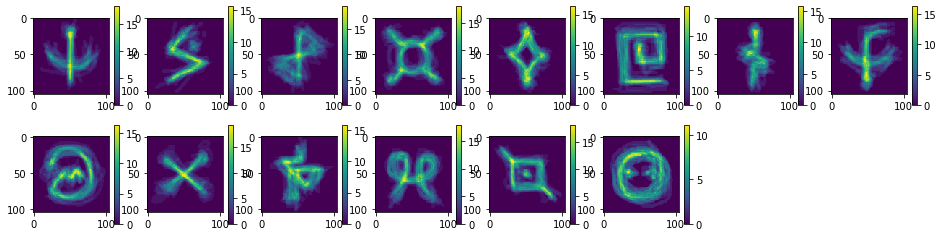

In [12]:
from scipy import misc
import cv2
from scipy.signal import correlate2d

# d = 'Latin'
d = 'Futurama'
# d = 'Braille'
# d = 'Korean'

# print(os.getcwd())
centered = bool(1)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 56
size = 105
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)
rows = 2
cols = n_class // rows + int( (n_class % rows) == 0 )
print(rows, cols)
fw = 2.
# over = np.ones((n_samp * n_class, n_samp * n_class)) * np.nan

img0 = np.zeros((size, size))
img1 = np.zeros((size, size))
img2 = np.zeros((size, size))
fig = plt.figure(figsize=(fw * cols, fw * rows))

for i0, c0 in enumerate(classes):
    files0 = sorted(glob.glob(os.path.join(path, c0, '*.png')))
#     print( cv2.imread(files0[0], cv2.IMREAD_GRAYSCALE).shape )
    img0[:] = 0
    img2[:] = cv2.resize(cv2.imread(files0[0], cv2.IMREAD_GRAYSCALE),
                             (size, size)) == 0
    whr = np.where(img2 > 0)
    r0 = -(np.mean(whr[0]) - (size // 2))
    c0 = -(np.mean(whr[1]) - (size // 2))
    T = np.float32([[1, 0, c0], [0, 1, r0]])
    img2[:] = cv2.warpAffine(img2, T, (size, size)) 

    for j0, f0 in enumerate(files0):
        img1[:] = cv2.resize(cv2.imread(f0, cv2.IMREAD_GRAYSCALE),
                             (size, size)) == 0
        
        if centered:
#             corr = correlate2d(img2, img1)
# #             print(corr.shape)
#             mx = np.argmax(corr)
# #             print(mx)
#             r0, c0 = 1 + mx // corr.shape[0], 1 + mx % corr.shape[0]
# #             print(r0, c0, corr[r0, c0])
#             r0 -= img1.shape[1]
#             c0 -= img1.shape[0]
#             print(r0, c0)
#             break
            
#             r0 *= -1
#             c0 *= -1
#             img1[:] = cv2.Canny(255*img1.astype('uint8'), 100, 200) * (1./255.)

            whr = np.where(img1 > 0)
            r0 = -(np.mean(whr[0]) - (size // 2))
            c0 = -(np.mean(whr[1]) - (size // 2))
            T = np.float32([[1, 0, c0], [0, 1, r0]])
            img1[:] = cv2.warpAffine(img1, T, (size, size)) 
#         #invert and sum
#         img0 += (img1 > 0) # * img1
        img0 += img1

#         plt.figure()
#         plt.imshow(img1.copy(), interpolation='none')#, cmap='gray')
#         plt.colorbar()
#         plt.show()
        
#         break
#     break
#     plt.figure()
    ax = plt.subplot(rows, cols, i0 + 1)
    plt.imshow(img0.copy(), interpolation='none')#, cmap='gray')
    plt.colorbar()
#     plt.show()
#     break
#                 print(i0, i1, j0, j1, v, size*size)

plt.savefig('full_dictionary_averages_{}_is_centered_{}.png'.format(d, centered), dpi=150)
plt.show()


/home/chanokin/sussex/l2l-omniglot
14 20 280
2 8


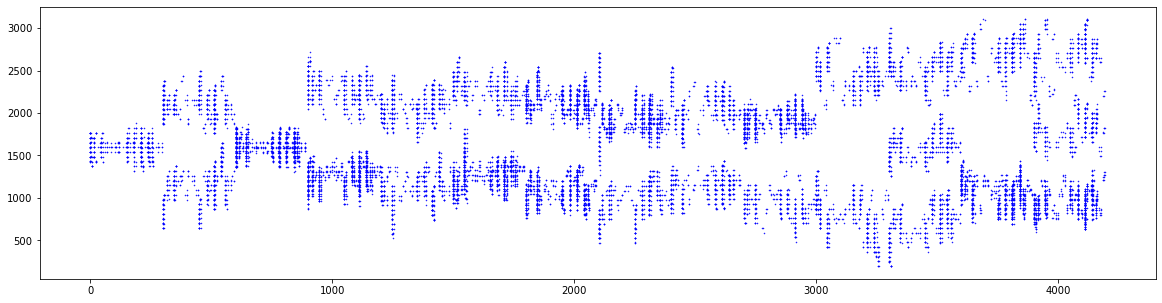

In [33]:
from scipy import misc
import cv2
from scipy.signal import correlate2d

# d = 'Latin'
# d = 'Futurama'
d = 'Braille'
# d = 'Korean'

print(os.getcwd())
# centered = bool(0)
path = '../omniglot/python/images_background/{}/'.format(d)
folders = sorted(glob.glob(os.path.join(path, '*')))
# print(folders)
classes = [os.path.basename(f) for f in folders][:14]
# print(folders)
# print(classes)
size = 56
n_class = len(classes)
n_samp = len(glob.glob( os.path.join(folders[0], '*.png') ))
print(n_class, n_samp, n_samp * n_class)
rows = 2
cols = n_class // rows + int( (n_class % rows) == 0 )
print(rows, cols)
fw = 2.
# over = np.ones((n_samp * n_class, n_samp * n_class)) * np.nan

img1 = np.zeros((size, size))
spikes = [[] for _ in range(size*size)]
ssa = []
# fig = plt.figure(figsize=(fw * cols, fw * rows))
dt = 15
x = 0
for i0, c0 in enumerate(classes):
    files0 = sorted(glob.glob(os.path.join(path, c0, '*.png')))
#     print( cv2.imread(files0[0], cv2.IMREAD_GRAYSCALE).shape )

    for j0, f0 in enumerate(files0):
        img1[:] = cv2.resize(cv2.imread(f0, cv2.IMREAD_GRAYSCALE),
                             (size, size)) == 0
        
        whr = np.where(img1 > 0)
        r0 = -(np.mean(whr[0]) - (size // 2))
        c0 = -(np.mean(whr[1]) - (size // 2))
        T = np.float32([[1, 0, c0], [0, 1, r0]])
        img1[:] = cv2.warpAffine(img1, T, (size, size)) * 255.
        
        ssa[:] = [[np.round( (255. - img1[r, c])*(10./127.))] 
                    if img1[r, c] > 127. else [] 
                        for r in range(size) for c in range(size)]
        
        for i, ts in enumerate(ssa):
            ts = np.asarray(ts) + dt * x
            spikes[i] += ts.tolist()

        x += 1

plt.figure(figsize=(20, 5))
for i, ts in enumerate(spikes):
    if len(ts):
        plt.plot(ts, i*np.ones_like(ts), '.b', markersize=1)
plt.show()


# plt.savefig('full_dictionary_averages_{}_is_centered_{}.png'.format(d, center), dpi=150)
# plt.show()


In [273]:
56/105.

0.5333333333333333

In [ ]:
from sklearn.datasets import fetch_openml
print('fetching mnist')
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print('done')


274


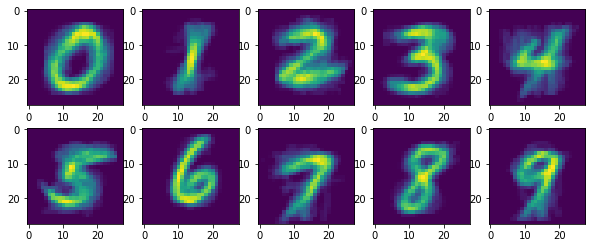

In [259]:
size = 28
n_class = 10
n_samp = 20
counts = [0 for _ in range(n_class)]
samples = [[] for _ in range(n_class)]
sums = [np.zeros((size, size)) for _ in range(n_class)]
for i, img in enumerate(X):
#     print(i)
    if np.allclose(n_samp, counts):
        print(i)
        break
    lbl = int(y[i])
    if counts[lbl] == n_samp:
#         print(lbl, i)
        continue
    sums[lbl] += img.reshape((size, size))
    samples[lbl].append(img.reshape((size, size)))
    counts[lbl] += 1 
    
plt.figure(figsize=(5*2, 2*2))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(sums[i], interpolation='none')#, cmap='gray')

plt.savefig('mnist_averages_n_samples_{}.png'.format(n_samp), dpi=150)
plt.show()

10 20 200
0
1
2
3
4
5
6
7
8
9


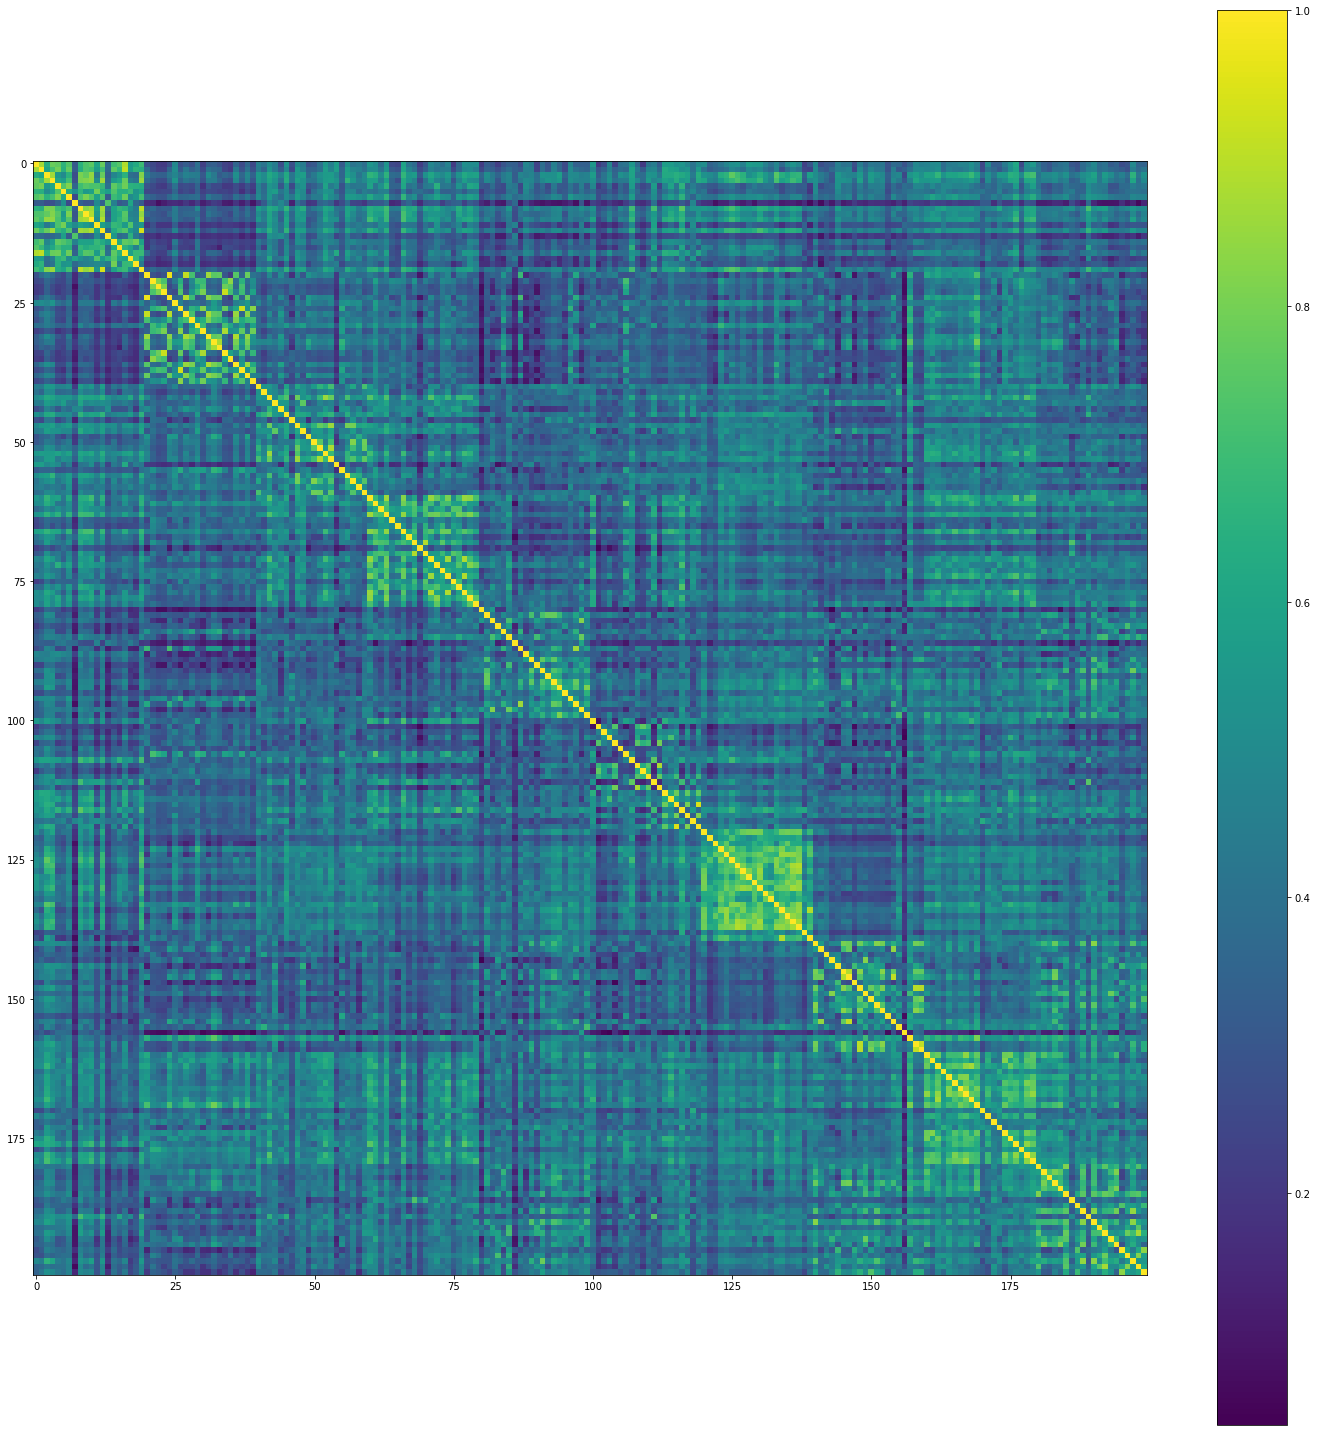

In [212]:
from scipy import misc
import cv2

classes = np.arange(n_class)
# print(folders)
# print(classes)
print(n_class, n_samp, n_samp * n_class)

over = np.ones((n_samp * n_class, n_samp * n_class)) * np.nan

img0 = np.zeros((size, size))
img1 = np.zeros((size, size))
for i0, c0 in enumerate(classes):
    print(i0)
    for i1, c1 in enumerate(classes):
        for j0 in range(n_samp):
            for j1 in range(n_samp):
                img0[:] = samples[i0][j0]
                img1[:] = samples[i1][j1]
                
                row, col = i0 * n_samp + j0, i1 * n_samp + j1 
#                 print(type(img0), type(img1))
                v = (img0 * img1).sum()/np.sqrt((img0**2).sum() * (img1**2).sum())
                over[row, col] = v

#                 print(i0, i1, j0, j1, v, size*size)
                
                
plt.figure(figsize=(20, 20))
plt.imshow(over, interpolation='none')
plt.colorbar()
plt.tight_layout()
plt.savefig('cross_correlation_characters_{}.png'.format("mnist"), dpi=150)
plt.show()


In [13]:
%load_ext autoreload
%autoreload 2

In [14]:
import pickle
import sys

In [15]:
sys.path.append('L2L')

In [16]:
sys.path.append('l2l-omniglot')

In [17]:
# fname = glob.glob('../titan/Trajectory*.bin')[0]
# t = pickle.load(open(fname, 'rb'))

In [18]:
from omnigloter import traj_utils as tu
from pprint import pprint

In [19]:
trajs = tu.open_all_trajectories('../titan')
pprint(trajs[99])
nine = trajs[99]
pprint(nine.individuals)


/home/chanokin/sussex/titan
/home/chanokin/sussex/titan/Trajectory_final_00000000000000000099.bin
{0: [{individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -0.8520, individual.etaFav:    -1.2725, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -1.8283, individual.kIF:    -0.4095, individual.kIS:    -1.2821, individual.kP:     0.0000, individual.pRewardSwitch:    -1.7000},
     {individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -0.8175, individual.etaFav:    -1.4843, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -2.0000, individual.kIF:    -0.6749, individual.kIS:    -1.1413, individual.kP:     0.0000, individual.pRewardSwitch:    -1.7000},
     {individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -0.9834, individual.etaFav:    -1.6308, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -1.9551, individual

      {individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -1.9739, individual.etaFav:    -1.5230, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -1.4976, individual.kIF:    -1.3848, individual.kIS:    -1.8002, individual.kP:     0.0000, individual.pRewardSwitch:    -1.7000},
      {individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -1.8347, individual.etaFav:    -1.6757, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -1.0605, individual.kIF:    -1.3705, individual.kIS:    -1.6415, individual.kP:     0.0000, individual.pRewardSwitch:    -1.7000},
      {individual.alpha:     0.0000, individual.beta:    -0.7000, individual.etaFap:    -1.9746, individual.etaFav:    -1.2999, individual.etaIF:    -0.3000, individual.etaIS:    -0.6000, individual.etaP:    -1.5137, individual.kIF:    -1.4607, individual.kIS:    -1.6893, individual.kP:     0.0000, individual.pRewardSwit

In [20]:
print(trajs[99].individuals.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])


In [21]:
print( tu.get_params(trajs[99]) )

{0: {0: {'alpha': 0.0, 'beta': -0.7, 'etaFap': -0.852041125329297, 'etaFav': -1.2724528906147161, 'etaIF': -0.3, 'etaIS': -0.6, 'etaP': -1.828311228598393, 'kIF': -0.40946661633167514, 'kIS': -1.2821123323594747, 'kP': 0.0, 'pRewardSwitch': -1.7}, 1: {'alpha': 0.0, 'beta': -0.7, 'etaFap': -0.8174532576522803, 'etaFav': -1.4843167298527418, 'etaIF': -0.3, 'etaIS': -0.6, 'etaP': -2.0, 'kIF': -0.6749090068241209, 'kIS': -1.1413078315277057, 'kP': 0.0, 'pRewardSwitch': -1.7}, 2: {'alpha': 0.0, 'beta': -0.7, 'etaFap': -0.9833907714374939, 'etaFav': -1.630809479597821, 'etaIF': -0.3, 'etaIS': -0.6, 'etaP': -1.955081770353113, 'kIF': -0.3894053901296992, 'kIS': -1.3742624296752026, 'kP': 0.0, 'pRewardSwitch': -1.7}, 3: {'alpha': 0.0, 'beta': -0.7, 'etaFap': -0.8220267093292306, 'etaFav': -1.8792736251098336, 'etaIF': -0.3, 'etaIS': -0.6, 'etaP': -1.807082795005165, 'kIF': -0.234539066506678, 'kIS': -1.3652554510390584, 'kP': 0.0, 'pRewardSwitch': -1.7}, 4: {'alpha': 0.0, 'beta': -0.7, 'etaFap

In [22]:
print(trajs[99].results.all_results)
gens = sorted( trajs[99].results.all_results.keys() )
last_g = gens[-1]
fits = [a[0] for i, a in trajs[99].results.all_results[last_g]]
print(fits)
print(np.mean(fits))

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: [], 12: [], 13: [], 14: [], 15: [], 16: [], 17: [], 18: [], 19: [], 20: [], 21: [], 22: [], 23: [], 24: [], 25: [], 26: [], 27: [], 28: [], 29: [], 30: [], 31: [], 32: [], 33: [], 34: [], 35: [], 36: [], 37: [], 38: [], 39: [], 40: [], 41: [], 42: [], 43: [], 44: [], 45: [], 46: [], 47: [], 48: [], 49: [], 50: [], 51: [], 52: [], 53: [], 54: [], 55: [], 56: [], 57: [], 58: [], 59: [], 60: [], 61: [], 62: [], 63: [], 64: [], 65: [], 66: [], 67: [], 68: [], 69: [], 70: [], 71: [], 72: [], 73: [], 74: [], 75: [], 76: [], 77: [], 78: [], 79: [], 80: [], 81: [], 82: [], 83: [], 84: [], 85: [], 86: [], 87: [], 88: [], 89: [], 90: [], 91: [], 92: [], 93: [], 94: [], 95: [], 96: [], 97: [], 98: [], 99: [(0, [4.217602]), (1, [5.265833]), (2, [4.8834996]), (3, [4.849275]), (4, [5.102036]), (5, [4.6521287]), (6, [4.8829975]), (7, [5.320979]), (8, [4.559699]), (9, [5.4258637]), (10, [5.2288904])]}
[4.217602, 5.26583

In [25]:
gens = sorted(trajs[99].results.generation_params.keys(),
             key=lambda x: int(x.split('_')[-1]))
params = trajs[99].results.generation_params
# print(params[gens[0]])
# print(gens)
for i, k in enumerate(gens):
    print(i, k, params[k].algorithm_params)


0 generation_0 {'best_fitness_in_run': 0.3183813571929932, 'generation': 0, 'current_fitness': 0.23675069808959961, 'average_fitness_in_run': 0.19326441775668748}
1 generation_1 {'best_fitness_in_run': 0.3413267135620117, 'generation': 1, 'current_fitness': 0.3022206783294678, 'average_fitness_in_run': 0.2465034604072571}
2 generation_2 {'best_fitness_in_run': 0.35694251060485843, 'generation': 2, 'current_fitness': 0.33630816936492924, 'average_fitness_in_run': 0.27225612876090144}
3 generation_3 {'best_fitness_in_run': 0.3745321750640869, 'generation': 3, 'current_fitness': 0.3358270883560181, 'average_fitness_in_run': 0.2831634886732156}
4 generation_4 {'best_fitness_in_run': 0.3769853591918946, 'generation': 4, 'current_fitness': 0.36671173572540283, 'average_fitness_in_run': 0.23955194472589278}
5 generation_5 {'best_fitness_in_run': 0.3956311225891114, 'generation': 5, 'current_fitness': 0.37072358131408695, 'average_fitness_in_run': 0.1850381462072785}
6 generation_6 {'best_fitn

In [ ]:
print( tu.get_fitnesses(trajs[99]) )

/home/chanokin/sussex/titan
/home/chanokin/sussex/titan/Trajectory_final_00000000000000000099.bin


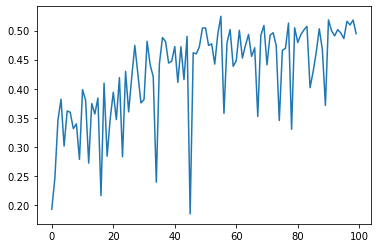

In [355]:

import numpy as np
import matplotlib.pyplot as pp
# import traj_utils as tu

# open trajectory files
trajs = tu.open_all_trajectories('../titan')
# extract generation numbers and sort them (ascending)
gens = sorted(trajs.keys())
# get the last trajectory (gens[-1] means get the last element in the array)
last_traj = trajs[gens[-1]]

# last generation is stored per individual
# extract generation numbers
gens = sorted(last_traj.results.all_results.keys())
# get the last generation
last_g = gens[-1]
# parse all fitnesses (a[0]) into an array
fits = [a[0] for i, a in last_traj.results.all_results[last_g]]
# compute the average and weigh it according to the main 
# python file (pid_mb_rl.py)
last_avg_fit = np.mean(fits) * 0.1

# just get a 'pointer' so it's less text in the code
gen_params = last_traj.results.generation_params
# this time get the generation_XX names and sort them
gens = sorted(gen_params.keys())

# create an array to store the data (+1 means the last gen)
af = np.zeros(len(gens)+1)
# add the last average generation fitness at the end (index -1)
af[-1] = last_avg_fit

# loop through generation_XX names [enumerate adds an index 
# so we now loop on index (0 to length of gens - 1) and name
# (generation_XX) ]
for i, g in enumerate(gens):
    af[i] = gen_params[g]['algorithm_params']['average_fitness_in_run']

# 'open' a figure/canvas
pp.figure()
# directly plot, no need for an 'x' coordinate
pp.plot(af)
# show the plot to the user
pp.show()


['conns', 'conn_list']
{0: array([[0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00],
       [0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00],
       ...,
       [3.135e+03, 1.700e+01, 0.000e+00, 1.000e+00],
       [3.135e+03, 1.800e+01, 0.000e+00, 1.000e+00],
       [3.135e+03, 1.900e+01, 0.000e+00, 1.000e+00]])}
20 3136


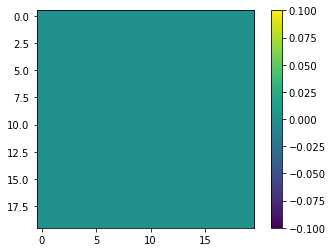

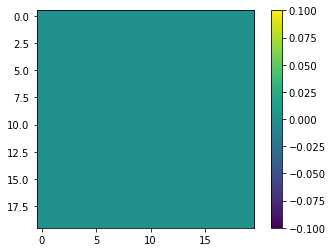

In [24]:
# np.float([111, 222])
with np.load('../titan/in_to_gain.npz', allow_pickle=True) as npz:
    print(list(npz.keys()))
    conns = {0: npz['conn_list']}#.item()
    print(conns)
    for l in conns:
        arr = np.asarray(conns[l])
        w = int( np.max(arr[:, 1]) ) + 1
        h = int( np.max(arr[:, 0]) ) + 1
        print(w, h)
        mtx = np.ones((w, w)) * np.nan
        
        sums = np.zeros((w, w))
        for r, c, v, d in arr:
#             r = int(r)
            c = int(c)
            mtx[:, c] = v
            sums[:, c] += v
            
        plt.figure()
        plt.imshow(mtx, vmin = 0)
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.imshow(sums, vmin = 0)
        plt.colorbar()
        plt.show()